# Optimizing Medical Support Center Allocation During Natural Disasters

In [1]:
%pip install pyomo networkx pandas numpy matplotlib --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import networkx as nx
import pandas as pd

In [3]:
# Reading the "node" CSV file into a pandas DataFrame
df = pd.read_csv('node.csv')

# Displaying the DataFrame
df.head(5)

,node,X,Y
0,1,690309,1976022
1,2,683649,1973025
2,3,693306,1963368
3,4,686313,1958373
4,5,696636,1946718


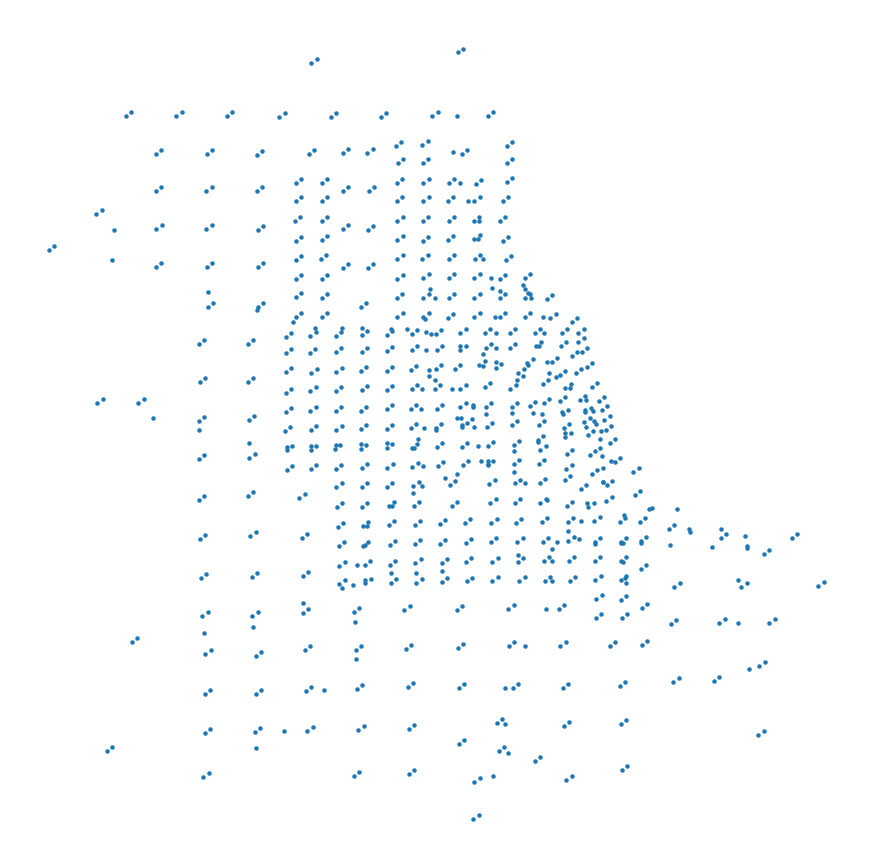

In [20]:
# Creating a scatter plot using the matplotlib library
plt.figure(figsize=(11,11))
plt.scatter(df['X'],df['Y'],s=5)

# Turning off the axis labels
plt.axis('off')

# Saving the plot as a PNG file
plt.savefig('base'+  '.png', format='png', dpi=200)

In [5]:
# Reading another CSV file, "net" into a DataFrame
net = pd.read_csv('net.csv')

# Displaying the DataFrame
net.head(5)

,f,t,cap,L,ftime,b,power,speed,toll,link_type,;
0,1,547,49500,0.86267,0.0,0.15,4,0,0,3,;
1,2,548,49500,0.86267,0.0,0.15,4,0,0,3,;
2,3,549,49500,0.86267,0.0,0.15,4,0,0,3,;
3,4,550,49500,0.86267,0.0,0.15,4,0,0,3,;
4,5,551,49500,0.86267,0.0,0.15,4,0,0,3,;


In [6]:
# create an empty Graph object from the NetworkX library
G = nx.Graph()

# create an empty dictionary called 'population'
population = {}

# loop through each node in the 'df' DataFrame and set a random population size
for n in df['node']:
    population[n] = 50*random.randint(10,200)

# create empty dictionaries called 'connect' and 'dist'
connect = {}
dist = {}

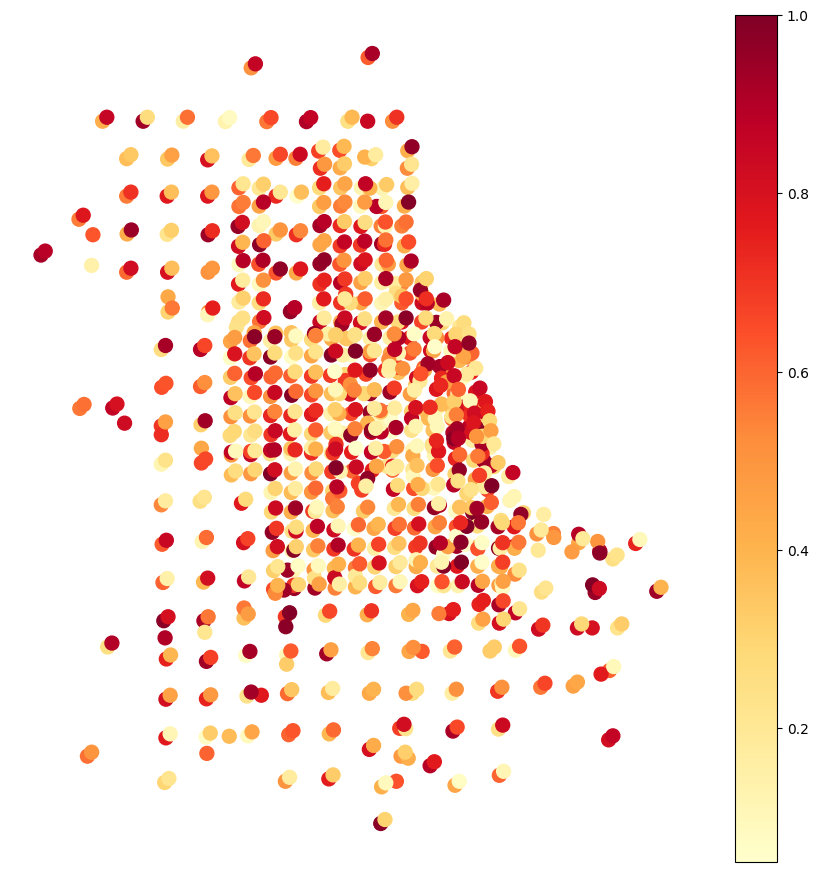

In [21]:
# Extract population size for each node from population dictionary
df['pop'] = [population[n] for n in population]

# Scale population size to range between 0 and 1
df['pop_scaled'] = df['pop'] / df['pop'].max()

# Create scatter plot with colormap based on population size
plt.figure(figsize=(11,11))
plt.scatter(df['X'], df['Y'], s=100, c=df['pop_scaled'], cmap='YlOrRd')

# Turn off axis and add colorbar to the plot
plt.axis('off')
plt.colorbar()

# Save the plot as png file
plt.savefig('base_population.png', format='png', dpi=200)

In [11]:
# Looping over each row in the net dataframe
for r in range(len(net)):
    # Get the starting node and ending node from the 'f' and 't' columns respectively
    f = int(net.loc[r,'f'])
    t = int(net.loc[r,'t'])
    # Get the length of the connection from the 'L' column
    L = net.loc[r,'L']
    # Add the connection in the connect dictionary
    connect[f,t]=L
    connect[t,f]=L
    # Get the coordinates of the starting and ending nodes
    xf= df.loc[f-1,'X']
    yf= df.loc[f-1,'Y']
    xt= df.loc[t-1,'X']
    yt= df.loc[t-1,'Y']
    # Calculate the distance between the two nodes using the coordinates
    #L= np.sqrt( (xf-xt)**2+ (yf-yt)**2)/1000
    # Add the connection as an edge in the graph G
    G.add_edge(f, t, weight=L)
    
# Loop over each pair of nodes to calculate the shortest distance between them
N = df['node'].max()
for f in range(1,N+1):
    for t in range(1,N+1):
        if f>t:
            if (f,t) in connect:
                # If there's already a connection between the two nodes, use the length of that connection
                dist[f,t], dist[t,f] = L , L 
            else:
                # If there's no direct connection between the two nodes, use the shortest path length in the graph G
                dist[f,t] = nx.shortest_path_length(G, source=f, target=t , weight='weight')
                dist[t,f] = dist[f,t]
                
# Get the values of all the calculated distances
S = dist.values()
# Print the minimum and maximum distances
min(S),max(S)

(1.03769, 170.34336999999994)

In [14]:
min(S),max(S)
#len(dist)
dist[1,574]

15.162609999999999

In [8]:
!apt-get install -y -qq coinor-cbc
!which cbc

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/bin/cbc


In [12]:
N = df['node'].max()  # get the maximum node number
model = AbstractModel()  # create an abstract model instance
model.i = RangeSet(N)  # define a range of nodes from 1 to N
model.j = Set(initialize=model.i)  # initialize the set of nodes
model.select = Var(model.i, initialize=0, within=Binary)  # create a binary variable select
model.reach = Var(model.i, initialize=0, within=Binary)  # create a binary variable reach

target1 = 60  # set target1 value
target2 = 20  # set target2 value
Ncar = 10  # set the maximum number of cars
Nreq = 1  # set the number of requests

# create constraint C1: each node i must be covered by at least one selected node within distance target1
def rule_C1(model, i):
    return model.select[i] + sum(model.select[j] for j in model.j if j != i and dist[i, j] <= target1) >= 1
model.C1 = Constraint(model.i, rule=rule_C1)

# create constraint C2: each node i must be covered by at least Nreq selected nodes within distance target2, and reach[i] must be 1 if node i is reached
def rule_C2(model, i):
    return model.select[i] + sum(model.select[j] for j in model.j if j != i and dist[i, j] <= target2) >= Nreq * model.reach[i]
model.C2 = Constraint(model.i, rule=rule_C2)

# create constraint C2A: each node i can be reached only if there are enough cars to reach it
def rule_C2A(model, i):
    return model.select[i] + sum(model.select[j] for j in model.j if j != i and dist[i, j] <= target2) - 1 <= Ncar * model.reach[i]
# model.C2A = Constraint(model.i, rule=rule_C2A)

# create constraint C4: the total number of selected nodes cannot exceed the maximum number of cars
def rule_C4(model):
    return sum(model.select[i] for i in model.i) <= Ncar 
model.C4 = Constraint(rule=rule_C4)

# set the objective function: maximize the total population covered by the selected nodes
def rule_OF(model):
    return (1e-5) * sum(model.reach[i] * population[i] for i in model.i)
model.obj = Objective(rule=rule_OF, sense=maximize)

opt = SolverFactory('cbc', executable='/usr/bin/cbc')
instance = model.create_instance()  # create instance

results = opt.solve(instance, options={"threads": 4, "ratio": 0.1})  # solve the instance using CBC solver

# check the feasibility and print the objective value
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print('Solver Status:', results.solver.status)  
print(value(instance.obj))  # print the objective value of the solved instance

feasible
47.519000000000005


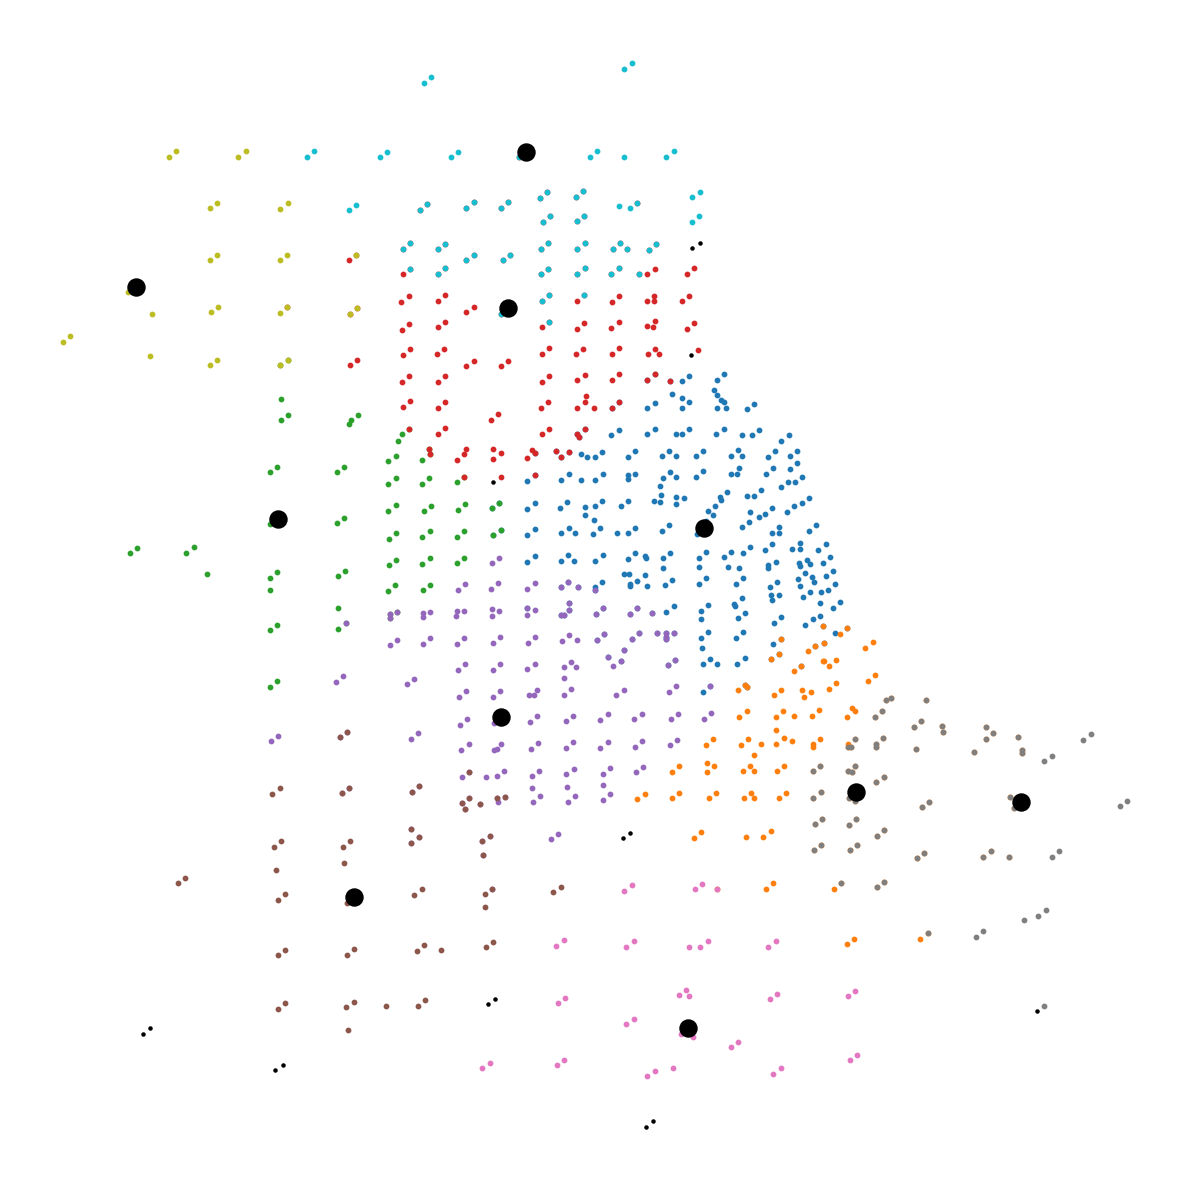

In [19]:
# Define color palette for plotting
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
Nc = len(KOLOR)

# Set plot size
plt.figure(figsize=(12,12))

# Initialize counter for cycling through colors
counter = 0 

# Iterate over locations
for i in instance.i:
    x1= df.loc[i-1,'X']
    y1= df.loc[i-1,'Y']
    
    # Check if location is selected as a center, plot as black dot
    if value(instance.select[i])>0:
        counter = counter%Nc
        plt.scatter(x1,y1,s=150, c='k',alpha=1, zorder= 2)
        
        # Find locations within coverage radius and plot as colored dots
        cover = [j for j in instance.j if i!=j and dist[i,j]<target2]
        X=[df.loc[j-1,'X'] for j in cover ]
        Y=[df.loc[j-1,'Y'] for j in cover ]
        
        plt.scatter(X,Y,s=10, c=KOLOR[counter], zorder= 1)
        counter+=1
        
# Plot all locations as small black dots
plt.scatter(df['X'],df['Y'],s=5, c='k', zorder = -1)

# Turn off axes and save plot
plt.axis('off')
plt.tight_layout()
plt.savefig('final_allocation_resul_1'+  ' .png', format='png', dpi=200)

624
668
720
757
817
877
897
906
914
920


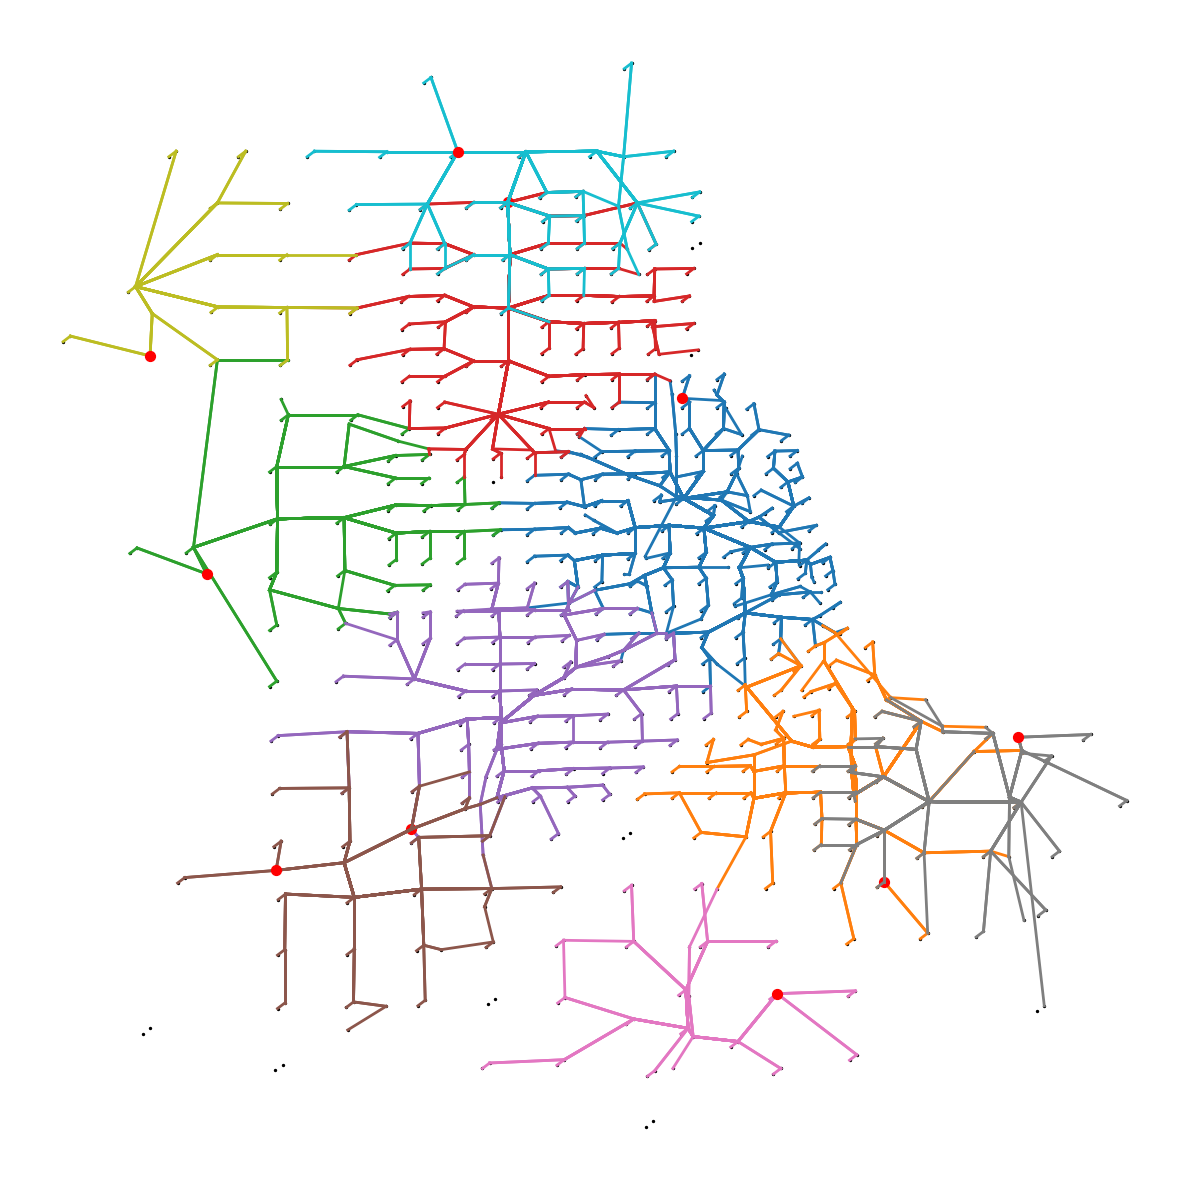

In [22]:
KOLOR=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig_size = (12,12)  # customize figure size here

plt.figure(figsize=fig_size)
plt.scatter(df['X'],df['Y'],s=2, c='k')
counter = 0 
for i in instance.i:
    x1= df.loc[i-1,'X']
    y1= df.loc[i-1,'Y']
    
    if value(instance.select[i])>0:
        cover = [j for j in instance.j if i!=j and dist[i,j]<target2]
        X=[df.loc[j-1,'X'] for j in cover ]
        Y=[df.loc[j-1,'Y'] for j in cover ]
        print(i)
        
        for j in cover:
            path = nx.shortest_path(G, source=i, target=j)
            for c in range(len(path)-1):
                p1 = path[c]
                p2 = path[c+1]
                x1= df.loc[p1-1,'X']
                y1= df.loc[p1-1,'Y']
                x2= df.loc[p2-1,'X']
                y2= df.loc[p2-1,'Y']
                plt.plot([x1,x2],[y1,y2],c=KOLOR[counter], lw=2)   
            
                
        #plt.scatter(X,Y,s=10, c=KOLOR[counter], zorder= 2)
        
        plt.scatter(x1,y1,s=50, c='r', zorder= 2)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('gradual cover'+ str(counter)+  ' .png', format='png', dpi=200)

        counter+=1
        counter = counter%Nc